In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from os.path import isdir, join, isfile
import re
from bokeh.plotting import figure, output_file, show

import bioframe
import cooltools
import cooler
import multiprocess as mp
from cooltools import expected
import pickle

In [4]:
def calc_cvds(path2mcools, chrom_arms, outdirectory):

    mcools = [join(path2mcools, file) for file in os.listdir(path2mcools) if isfile(join(path2mcools, file)) and file.split("mm10.")[1] == "mapq_30.100.mcool"]
    
    for file in mcools:
        fh = file.split("/")[-1]
        exp_info = fh.split(".")[0]

        clr = cooler.Cooler(join(file.rstrip("/")+"::resolutions/1000"))
    
        with mp.Pool(5) as p: # Parallelize across 5 threads
            cvd = expected.diagsum( # cvd is short for contacts vs distance
                clr=clr,
                regions=chrom_arms,
                transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}, 
                map=p.map # Parallelize across 5 threads
            )

        with open(outdirectory+exp_info+"_cvd.pkl", "wb") as outfile:
            pickle.dump(cvd, outfile)


def _get_lbs(condition_data, binsize):
    
    condition = condition_data[0]
    cvd = condition_data[1]
    
    lb_cvd, lb_slopes, lb_distbins = expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = expected.combine_binned_expected(lb_cvd, binned_exp_slope=lb_slopes)

    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * binsize
    
    return(condition, lb_cvd_agg, lb_slopes_agg)


def compare_scalings(full_experiment_dir, binsize, outdirectory):
    
    for experiment_set in full_experiment_dir.keys():
        exp_set_vals = full_experiment_dir[experiment_set]
        
        f, axs = plt.subplots(
            figsize=(6.5,13),
            nrows=2, 
            gridspec_kw={'height_ratios':[6,2]}, 
            sharex=True
        )        
        
        for indiv_experiment in sorted(exp_set_vals):
            condition, lb_cvd_agg, lb_slopes_agg = _get_lbs(indiv_experiment, binsize)
            
            ax = axs[0]
            ax.loglog(
                lb_cvd_agg['s_bp'],
                lb_cvd_agg['balanced.avg'] / lb_cvd_agg['balanced.avg'].iloc[2],
                alpha=0.5,
                label=condition
            )

            ax = axs[1]
            ax.semilogx(
                lb_slopes_agg['s_bp'],
                lb_slopes_agg['slope'],
                alpha=0.5
            )

        axs[0].set(title=experiment_set, xlabel='separation, bp', ylabel='IC contact frequency')
        axs[0].set_aspect(1.0)
        axs[0].grid(lw=0.5)
        _=axs[0].legend()

        axs[1].set(xlabel='separation, bp', ylabel='slope')
        axs[1].grid(lw=0.5)
        
        plt.savefig(outdirectory+experiment_set+'.png')

In [5]:
lib_group_mcools_path = "../distiller-nf/results/coolers_library_group/"

mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_arms = [(mm10_chromsizes.index[i], 0, mm10_chromsizes.values[i]) for i in range(len(mm10_chromsizes))]

lib_group_cvd_path = "../cvd_lib_groups/"
calc_cvds(lib_group_mcools_path, mm10_arms, outdirectory=lib_group_cvd_path)


In [ ]:
lib_mcools_path = "../distiller-nf/results/coolers_library/"
lib_cvd_path = "../cvd_lib_replicates/"
calc_cvds(lib_group_path, mm10_arms, outdirectory=lib_group_cvd_path)

In [ ]:
rel_path = "../distiller-nf/results/coolers_library/"
mcools = [join(rel_path, file) for file in os.listdir(rel_path) if isfile(join(rel_path, file)) and file.split("mm10.")[1] == "mapq_30.100.mcool"]

mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_arms = [(mm10_chromsizes.index[i], 0, mm10_chromsizes.values[i]) for i in range(len(mm10_chromsizes))]

In [ ]:
# Calculating and storing cvd as .pkl files
for file in mcools:
    fh = file.split("/")[-1]
    exp_info = fh.split(".")[0]
    
    clr = cooler.Cooler(join(file.rstrip("/")+"::resolutions/1000"))
    
    with mp.Pool(5) as p: # Parallelize across 5 threads
        cvd = expected.diagsum( # cvd is short for contacts vs distance
            clr=clr,
            regions=mm10_arms,
            transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}, 
            map=p.map # Parallelize across 5 threads
        )
    
    with open("../cvd"+exp_info+"_cvd.pkl", "wb") as outfile:
        pickle.dump(cvd, outfile)
        

In [ ]:
cvd_pkl_path = "../cvd/"
cvds = [join(cvd_pkl_path, file) for file in os.listdir(cvd_pkl_path) if isfile(join(cvd_pkl_path, file))]

all_experiment_dir = {}
for file in cvds:
    fh = file.split("/")[-1]
    experiment = re.match("([a-zA-Z0-9]*_[a-zA-Z0-9]*)", fh).group(0)
    rep = re.search("rep[0-9]", fh).group(0)
    
    with open(file, "rb") as infile:
        cvd = pickle.load(infile)
        
    if experiment in all_experiment_dir.keys():
        all_experiment_dir[experiment].append((rep, cvd))
    else:
        all_experiment_dir[experiment] = [(rep, cvd)]

binsize = 1000
compare_scalings(all_experiment_dir, binsize=binsize, outdirectory="../Hsieh2021_replicates_scalings/")

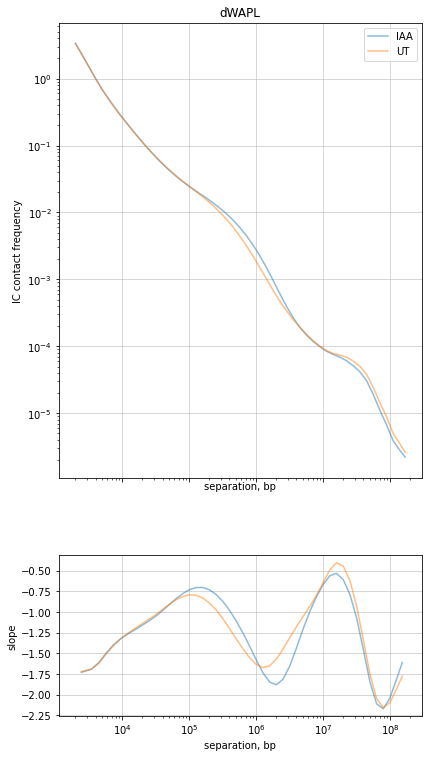

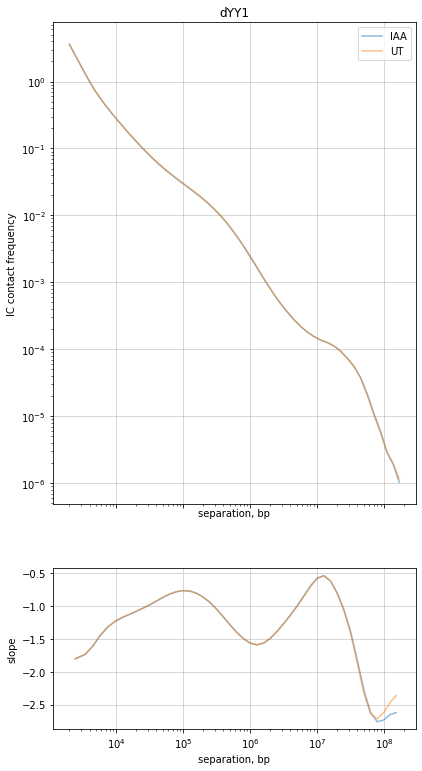

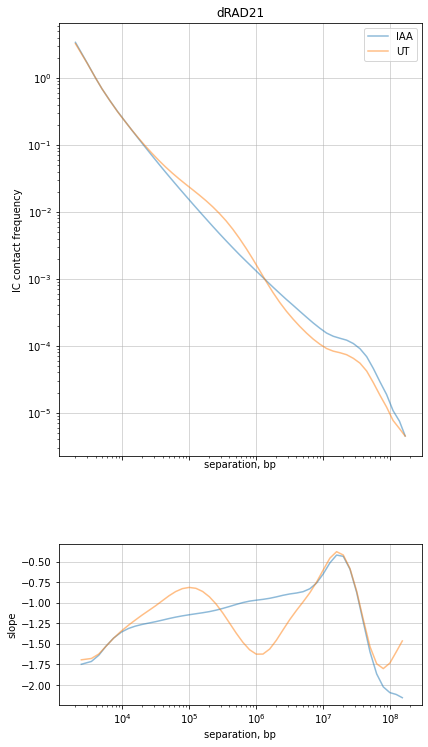

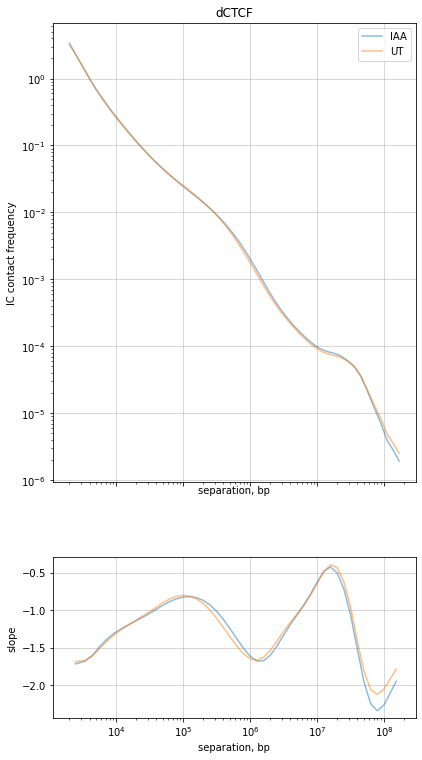

In [8]:
lib_group_cvds = [join(lib_group_cvd_path, file) for file in os.listdir(lib_group_cvd_path) if isfile(join(lib_group_cvd_path, file))]

UT_v_IAA_exp_dir = {}
for file in lib_group_cvds:
    fh = file.split("/")[-1]
    experiment = fh.split("_")[0]
    treatment = fh.split("_")[1]
    
    with open(file, "rb") as infile:
        cvd = pickle.load(infile)
    
    if experiment in UT_v_IAA_exp_dir.keys():
        UT_v_IAA_exp_dir[experiment].append((treatment, cvd))
    else:
        UT_v_IAA_exp_dir[experiment] = [(treatment, cvd)]

binsize = 1000
compare_scalings(UT_v_IAA_exp_dir, binsize=binsize, outdirectory="../Hsieh2021_IAAvsUT_scalings/")      

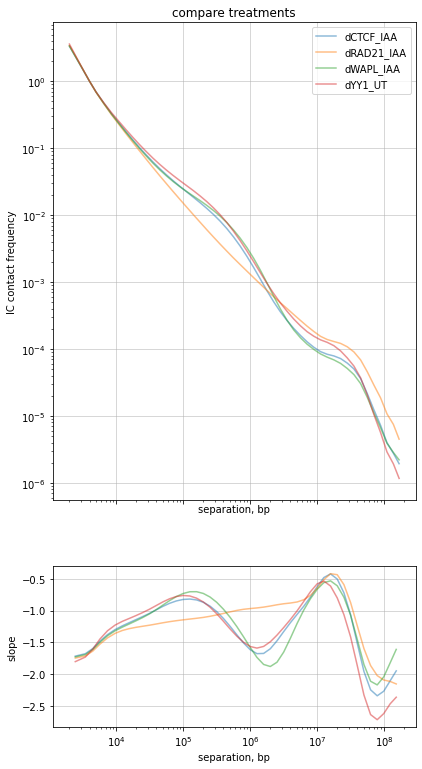

In [34]:
test_dir = {}
for file in lib_group_cvds:
    fh = file.split("/")[-1]
    experiment = fh.split("_")[0]
    treatment = fh.split("_")[1]
    
    with open(file, "rb") as infile:
        cvd = pickle.load(infile)
    
    if experiment not in test_dir.keys():
        test_dir[experiment] = {}
    test_dir[experiment][treatment] = cvd

compare_treatments = {
    "compare treatments": []
}

for key, val in test_dir.items():
    if key == "dYY1":
        compare_treatments["compare treatments"].append((key+"_UT", val["UT"]))
    else:
        compare_treatments["compare treatments"].append((key+"_IAA", val["IAA"]))

compare_scalings(compare_treatments, binsize=1000, outdirectory="../Hsieh2021_IAAvsUT_scalings/")